# 1. Importing Packages

In [1]:
# %pip install python-dotenv
# %pip install sasctl
# %pip install seaborn --upgrade
# %pip install imbalanced-learn
# %pip install tqdm
# %pip install hyperopt

In [3]:
import os
import json
import math
import joblib
import pickle
import requests
import warnings
import numpy as np
import pandas as pd
#import sdm_generate
from tqdm import tqdm
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
from dotenv import load_dotenv, find_dotenv

from sasviya.ml.tree import ForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, recall_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV

from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sasctl import pzmm
from pathlib import Path
from sasctl import Session
from sasctl.services import model_repository as mr, model_management as mm

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

In [4]:
warnings.filterwarnings("ignore")

# 2. Data Collection (SAS Synthetic Data Generator API)

In [9]:
rc, zip_file = sdm_generate.generate_synthetic_data("./churn_demo/CDADEMO_CUSTOMER_CHURN_TRAIN.csv", 10000, 3)

Synthetic Data Saved:  generated_data_20240517_014052.zip


In [10]:
temp_dir, file_list = sdm_generate.unzip_and_list(zip_file)
temp_dir, file_list

Extracted ZIP file to:  /workspaces/test/Innovate-Demo/data/output/generated_data_20240517_014052.zip_unzipped
Unzipped files:  ['advisor.json', 'generated.csv', 'generated_top_100.csv', 'input_top_100.csv', 'timing.json', 'assessments/VariableDistributions.csv', 'assessments/FrequencyDistributions.csv', 'assessments/Binning.csv', 'assessments/Correlation.csv', 'assessments/CorrelationDiffNorm.csv', 'assessments/PCACorrelation.csv', 'assessments/PCAScore.csv', 'assessments/PCAEigenvector.csv', 'assessments/PCAEigenvalue.csv']


('/workspaces/test/Innovate-Demo/data/output/generated_data_20240517_014052.zip_unzipped',
 ['advisor.json',
  'generated.csv',
  'generated_top_100.csv',
  'input_top_100.csv',
  'timing.json',
  'assessments/VariableDistributions.csv',
  'assessments/FrequencyDistributions.csv',
  'assessments/Binning.csv',
  'assessments/Correlation.csv',
  'assessments/CorrelationDiffNorm.csv',
  'assessments/PCACorrelation.csv',
  'assessments/PCAScore.csv',
  'assessments/PCAEigenvector.csv',
  'assessments/PCAEigenvalue.csv'])

# 3. Exploratory Data Analysis (EDA)

In [5]:
df = pd.read_csv("./data/output/generated_data_20240517_014052.zip_unzipped/generated.csv", low_memory=False)

# First split: train and test
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (8000, 19)
Test data shape: (2000, 19)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   wksSinceFirstPurch      10000 non-null  float64
 1   socialMediaAdCount36    10000 non-null  float64
 2   wksSinceLastPurch       10000 non-null  float64
 3   intAdExposureCount12    10000 non-null  float64
 4   totalNumProdPurchased   10000 non-null  float64
 5   intAdExposureCount36    10000 non-null  float64
 6   socialMediaAdCountAll   10000 non-null  float64
 7   regionPctCustomers      10000 non-null  float64
 8   ID                      10000 non-null  float64
 9   intAdExposureCountAll   10000 non-null  float64
 10  DemHomeOwner            10000 non-null  object 
 11  LostCustomer            10000 non-null  int64  
 12  numOfTotalReturns       10000 non-null  int64  
 13  customerGender          10000 non-null  object 
 14  basktPurchCount12Month  10000 non-null 

<div class="alert alert-info" role="alert">
    There are also object datatypes present within the data which need to be encoded into numerical values. Do note that this is an issue that is present within open source ML libraries like sci-kit learn, the SAS libraries can handle object datatypes as well. 
</div>

In [7]:
df.isna().sum()

wksSinceFirstPurch        0
socialMediaAdCount36      0
wksSinceLastPurch         0
intAdExposureCount12      0
totalNumProdPurchased     0
intAdExposureCount36      0
socialMediaAdCountAll     0
regionPctCustomers        0
ID                        0
intAdExposureCountAll     0
DemHomeOwner              0
LostCustomer              0
numOfTotalReturns         0
customerGender            0
basktPurchCount12Month    0
customerSubscrStat        0
socialMediaAdCount12      0
custInitiatedContacts     0
techSupportEval           0
dtype: int64

In [8]:
df.duplicated().sum()

163

<div class="alert alert-info" role="alert">
    There are no null values in the dataset which is a good sign. This means we do not have to perform any data imputation. However, there are duplicate values present which will skew the modelling results. 
</div>

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
wksSinceFirstPurch,10000.0,89.0806,34.494679,39.0,57.00,86.0,116.00,166.0
socialMediaAdCount36,10000.0,10.7508,4.853149,1.0,6.00,11.0,15.00,28.0
wksSinceLastPurch,10000.0,17.8903,4.184736,4.0,16.00,18.0,20.00,27.0
intAdExposureCount12,10000.0,13.5031,5.426098,2.0,11.00,12.0,14.00,45.0
totalNumProdPurchased,10000.0,8.8325,7.218092,1.0,3.00,7.0,13.00,64.0
intAdExposureCount36,10000.0,28.8505,8.600462,4.0,24.00,30.0,33.00,65.0
socialMediaAdCountAll,10000.0,17.9544,8.669673,2.0,11.00,18.0,25.00,61.0
regionPctCustomers,10000.0,31.3703,9.580248,0.0,26.00,31.0,37.00,75.0
ID,10000.0,83142.4637,58747.794523,258.0,44330.75,71813.5,130975.75,191753.0
intAdExposureCountAll,10000.0,46.8067,23.695824,4.0,27.00,47.0,64.00,151.0


<div class="alert alert-info" role="alert">
    There are some of the summary statistics that we have. Since the data comes from SAS SDG, some of this data and summary statistics are automatically generated as visuals for us. This data will be visualized below. 
</div>

## SAS provided data assessments

### Read Column Information

In [10]:
temp_dir = "./data/output/generated_data_20240517_014052.zip_unzipped"

def get_advisor_results(temp_dir: str) -> pd.DataFrame:
    advisor_json_file = os.path.join(temp_dir, "advisor.json")
    with open(advisor_json_file) as json_data:
        data = json.load(json_data)
    return pd.DataFrame(data["variables"])


advisor_results = get_advisor_results(temp_dir)
display(advisor_results)

,name,role,level,comment,precision
0,ID,INPUT,INTERVAL,,0.0
1,DemHomeOwner,INPUT,NOMINAL,,NaN
2,LostCustomer,INPUT,NOMINAL,,NaN
3,regionPctCustomers,INPUT,INTERVAL,,0.0
4,numOfTotalReturns,INPUT,NOMINAL,,NaN
5,wksSinceLastPurch,INPUT,INTERVAL,,0.0
6,customerGender,INPUT,NOMINAL,,NaN
7,basktPurchCount12Month,INPUT,NOMINAL,,NaN
8,LastPurchaseAmount,REJECTED,NOMINAL,The variable exceeds the maximum number of lev...,NaN
9,AvgPurchaseAmount12,REJECTED,NOMINAL,The variable exceeds the maximum number of lev...,NaN


### Variable Distributions

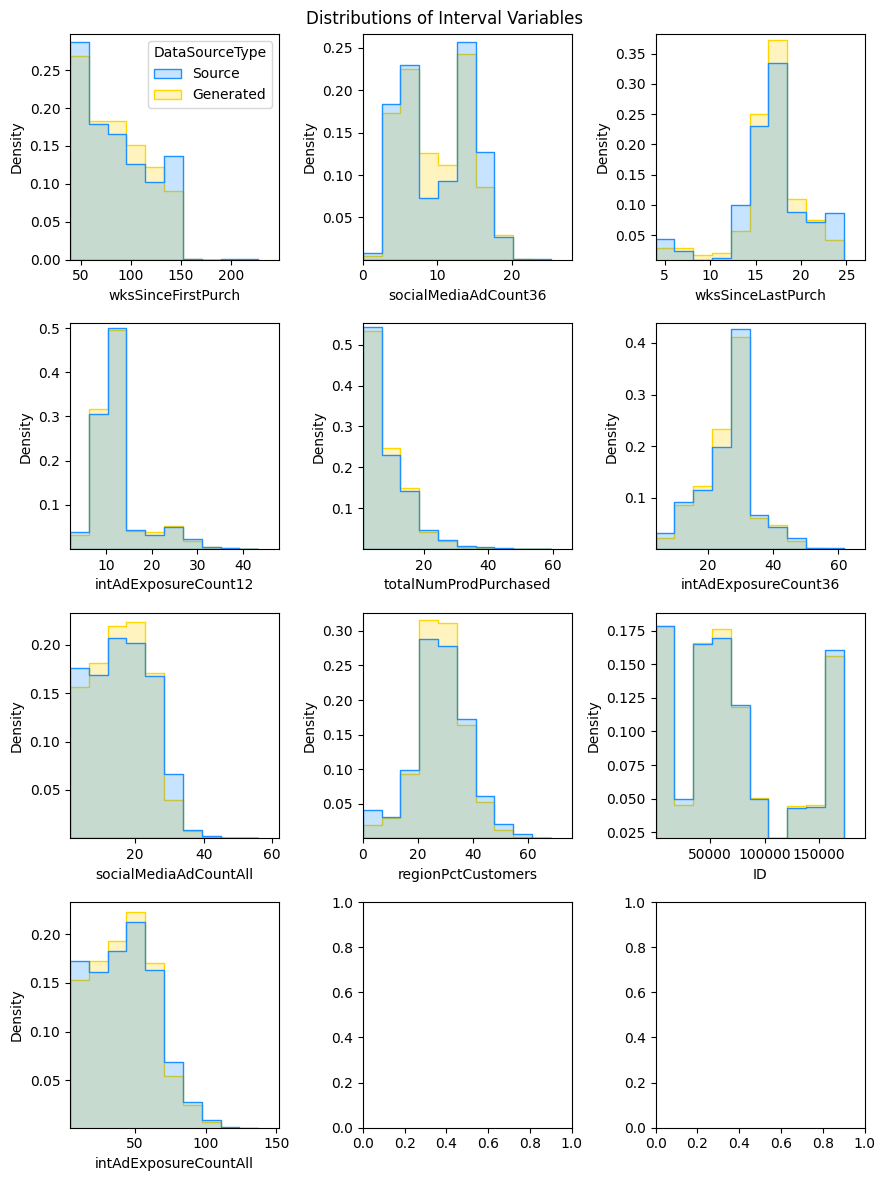

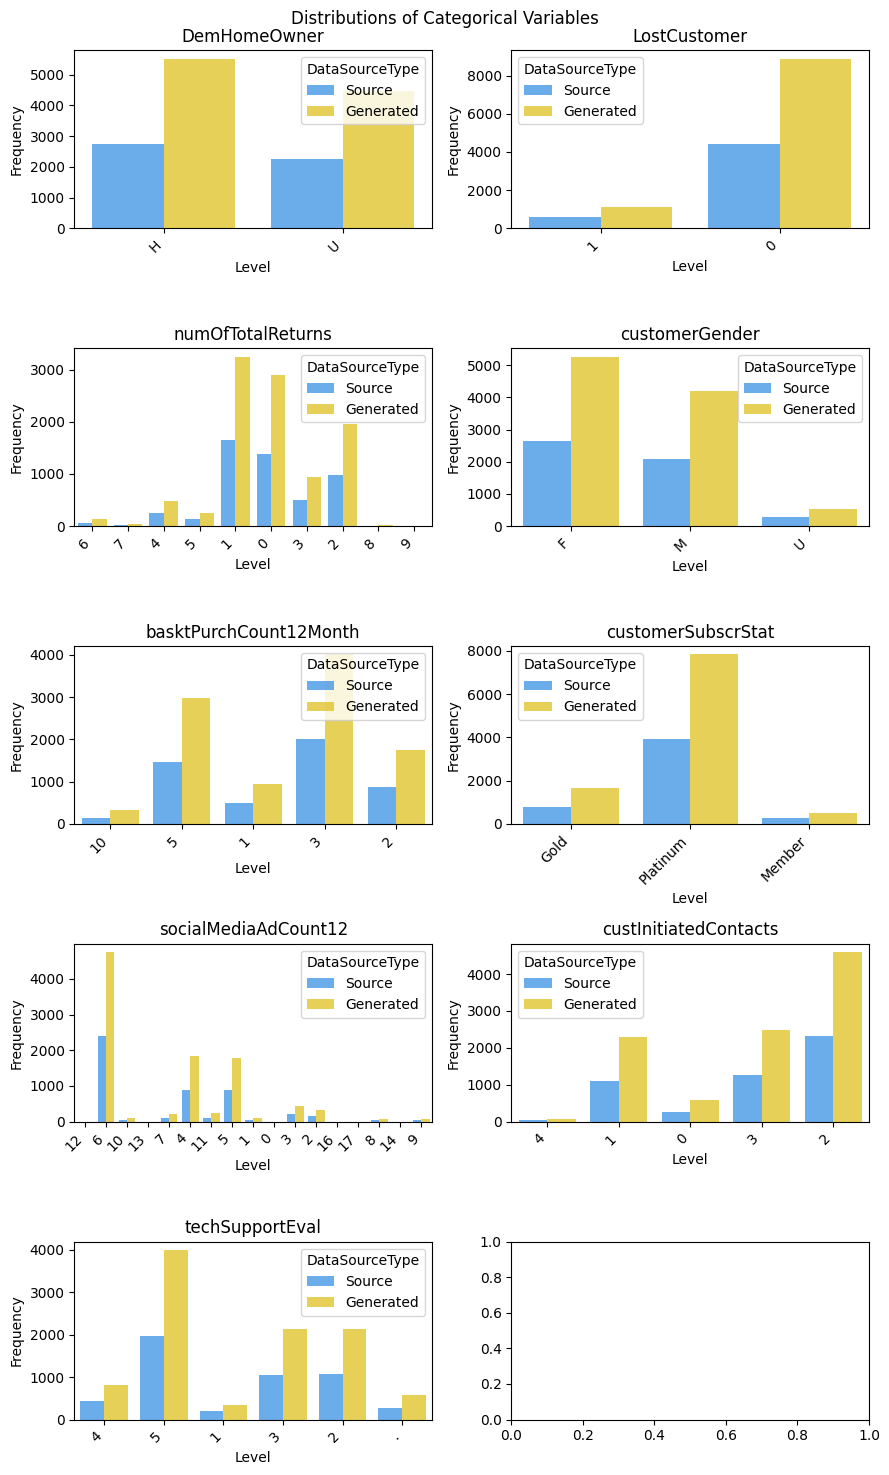

In [11]:
name_map = {"BASE": "Source", "COMPARE": "Generated"}


def plot_histogram_overlay(df, variables):
    num_rows = math.ceil(len(variables) / 3)
    num_cols = min(3, len(variables))
    fig, ax = plt.subplots(num_rows, num_cols, figsize = (9, 3*num_rows))

    df['DataSourceType'] = df['DataSourceType'].map(name_map)
    for i, variable in enumerate(variables):
        if num_rows > 1:
            ax_to_plot = ax[math.floor(i/3), i%3]
        else:
            ax_to_plot = ax[i]
        vdf = df[df["Variable"] == variable]
        vdf = vdf.assign(NormBinCount=vdf["BinCount"].div(vdf.groupby('DataSourceType')["BinCount"].transform('sum')))
        orig_vdf = vdf[vdf["DataSourceType"] == "Source"]
        bins = pd.concat([orig_vdf["BinLowerBound"], orig_vdf["BinUpperBound"][-1:]], ignore_index=True)
        p = sns.histplot(ax=ax_to_plot, data=vdf, x="BinLowerBound", weights="NormBinCount", bins=len(bins) - 1, hue="DataSourceType", element="step", palette=["dodgerblue", "gold"])
        ax_to_plot.set(xlabel=variable, ylabel="Density")
        if i > 0: # only show the legend on the first one
            ax_to_plot.legend([],[], frameon=False)

        # bounds
        x_min = vdf["BinLowerBound"].min()
        x_max = vdf["BinUpperBound"].max()
        y_min = vdf["NormBinCount"].min()
        y_max = vdf["NormBinCount"].max() + 0.01
        ax_to_plot.set_xlim(xmin=x_min, xmax=x_max)
        ax_to_plot.set_ylim(ymin=y_min, ymax=y_max)

    fig.suptitle("Distributions of Interval Variables")
    fig.tight_layout()

def plot_categorical_vars(df, variables):
    num_rows = math.ceil(len(variables) / 2)
    num_cols = min(2, len(variables))
    fig, ax = plt.subplots(num_rows, num_cols, figsize = (9, 3*num_rows))

    df['DataSourceType'] = df['DataSourceType'].map(name_map)

    for i, variable in enumerate(variables):
        if num_rows > 1:
            ax_to_plot = ax[math.floor(i/2), i%2]
        else:
            ax_to_plot = ax[i]
        levels = df.loc[df['Variable'] == variable]['Level'].unique()
        
        x = np.arange(len(levels))
        p = sns.barplot(ax=ax_to_plot, data=df[df['Variable'] == variable], x="Level", y="Frequency", hue='DataSourceType', palette=["dodgerblue", "gold"], alpha=0.75)
        ax_to_plot.set_title(variable)
        ax_to_plot.set_xticks(x, levels)
        ax_to_plot.set_xticklabels(levels, rotation=45, ha='right')
    
    fig.suptitle("Distributions of Categorical Variables")
    fig.tight_layout()


assessments_dir = "./data/output/generated_data_20240517_014052.zip_unzipped/assessments"
bin_filename = os.path.join(assessments_dir, "Binning.csv")
binning_df = pd.read_csv(bin_filename)

# Convert columns to numeric where needed
cols = binning_df.columns.drop(['DataSourceType', 'Variable'])
binning_df[cols] = binning_df[cols].apply(pd.to_numeric, errors='coerce')

interval_vars = binning_df["Variable"].unique()
plot_histogram_overlay(binning_df, interval_vars)

freq_filename = os.path.join(assessments_dir, "FrequencyDistributions.csv")
freq_df = pd.read_csv(freq_filename)

var_names = freq_df["Variable"].unique()
plot_categorical_vars(freq_df, var_names)

### Correlation Information

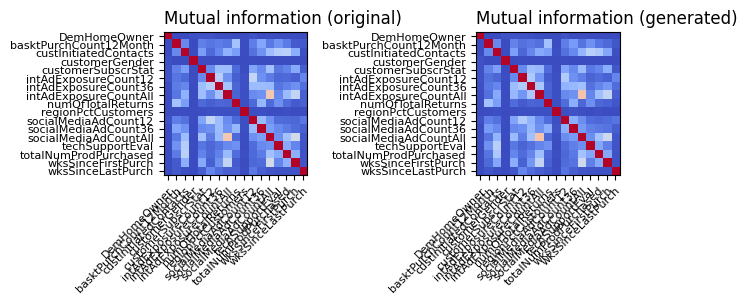

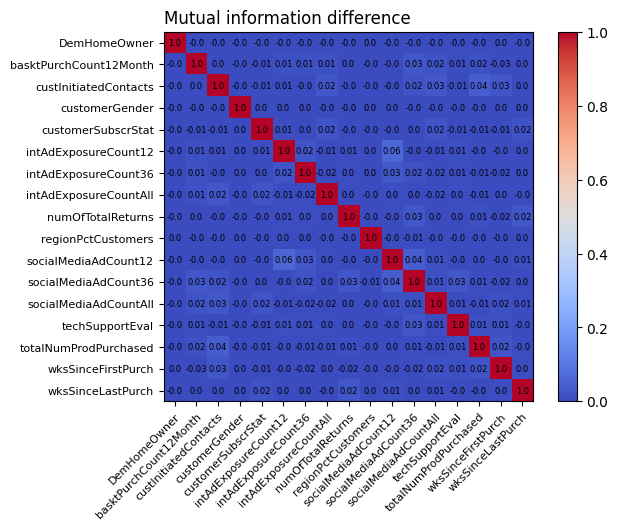

In [12]:
plt.rcParams["axes.grid"] = False

def matrix_data_for_type(df, data_type):
    # Reformat for plot
    orig_df = df[df['DataSourceType'] == data_type].reset_index()

    # map var names to index
    s1 = orig_df['FirstVariable']
    s2 = orig_df['SecondVariable']
    vars = pd.concat([s1,s2], ignore_index=True).unique()
    vars.sort()

    num_vars = len(vars)
    matrix_data = np.zeros((num_vars, num_vars), dtype=np.float64)

    var_dict = dict()
    for i in range(len(vars)):
        var_dict[vars[i]] = i
        matrix_data[i][i] = 1

    for index, row in orig_df.iterrows():
        i = var_dict[row['FirstVariable']]
        j = var_dict[row['SecondVariable']]
        matrix_data[i][j] = row['MI']
        matrix_data[j][i] = row['MI']

    return vars, matrix_data

def plot_matrix(ax, data, vars, title=None, show_values=False, colorbar=False):
    im = ax.imshow(data, cmap='coolwarm', vmin=0, vmax=1) 
    if title is not None:
        ax.set_title(title, loc='left')

    if colorbar:
        ax.figure.colorbar(im, ax = ax)
 
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(vars)), labels=vars, size=8)
    ax.set_yticks(np.arange(len(vars)), labels=vars, size=8)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    if show_values:
        for i in range(len(vars)):
            for j in range(len(vars)):
                text = ax.text(j, i, np.round(data[i, j], 2), ha="center", va="center", size=6)

correlation_filename = os.path.join(assessments_dir, "Correlation.csv")
correlation_df = pd.read_csv(correlation_filename)
correlation_df = correlation_df.loc[~((correlation_df["FirstVariable"] == 'ID') | (correlation_df["FirstVariable"] == 'LostCustomer') | (correlation_df["SecondVariable"] == 'LostCustomer'))]


vars, orig_matrix = matrix_data_for_type(correlation_df, 'BASE')
_, gen_matrix = matrix_data_for_type(correlation_df, 'COMPARE')
_, diff_matrix = matrix_data_for_type(correlation_df, 'DIFFERENCE')

fig, (ax1, ax2) = plt.subplots(1, 2)

plot_matrix(ax1, orig_matrix, vars, title="Mutual information (original)")
plot_matrix(ax2, gen_matrix, vars, title="Mutual information (generated)")
fig.tight_layout()

fig2, ax = plt.subplots()
plot_matrix(ax, diff_matrix, vars, show_values=True, colorbar=True, title="Mutual information difference")

## EDA on Demographic Information

- DemHomeOwner: Homeowner indicator
- customerGender: Gender of the customer

In [13]:
# creating a utility plotting function

def plot_distribution(column):
    labels = column.value_counts().index
    values = column.value_counts().values

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    axs[0].set_title(f'{column.name} Distribution (Pie Chart)')

    axs[1].bar(labels, values)
    axs[1].set_title(f'{column.name} Distribution (Bar Chart)')
    axs[1].set_xlabel(column.name)
    axs[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

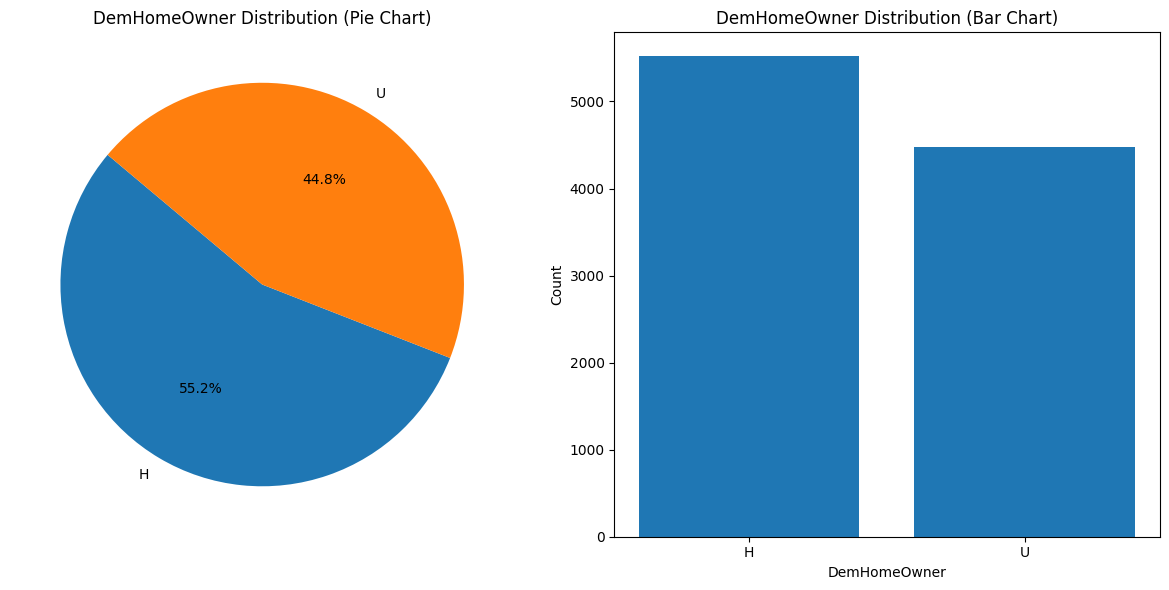

In [14]:
plot_distribution(df["DemHomeOwner"])

<div class="alert alert-info" role="alert">
    Assuming that H is homeowner and U is unknown, we can see that these 2 groups are relatively similar.
</div>

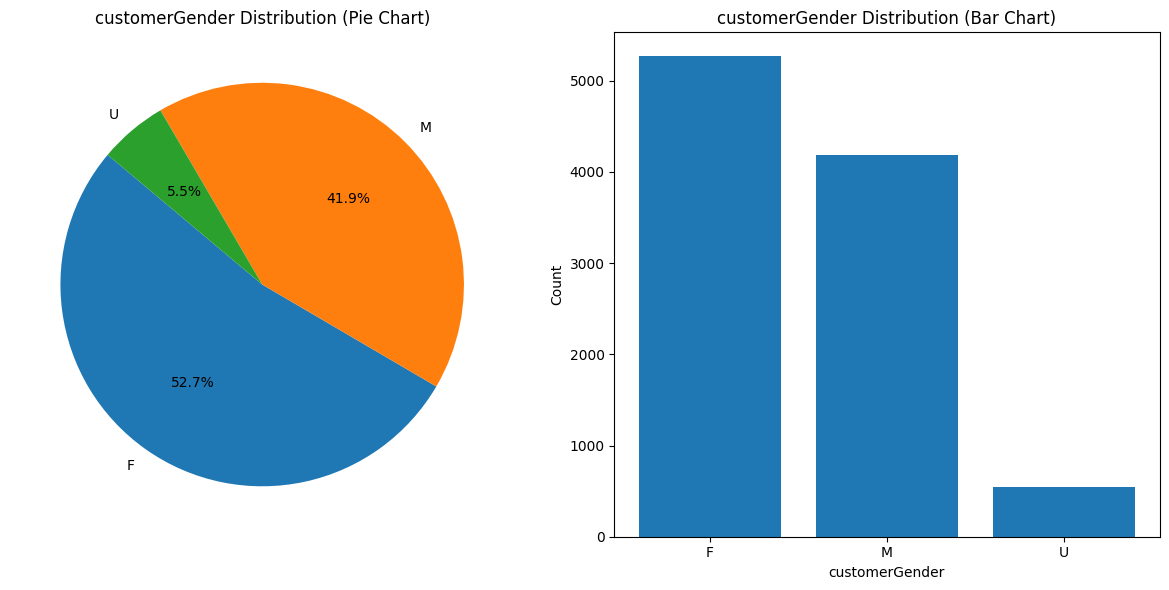

In [15]:
plot_distribution(df["customerGender"])

<div class="alert alert-info" role="alert">
    There is a small percentage of unknown genders. This is just acting as noise in our data so we can remove it. 
</div>

## EDA on Customer Behaviour

- LostCustomer: Indicator if the customer is lost (binary) **[TARGET COLUMN]**
- regionPctCustomers: Percentage of customers in the region
- numOfTotalReturns: Total number of returns
- wksSinceLastPurch: Weeks since the last purchase
- basktPurchCount12Month: Basket purchase count in the last 12 months
- LastPurchaseAmount: Amount of last purchase
- AvgPurchaseAmount12: Average purchase amount in the last 12 months
- AvgPurchaseAmountTotal: Total average purchase amount
- totalNumProdPurchased: Total number of products purchased
- custInitiatedContacts: Customer-initiated contacts
- customersales: Customer sales
- techSupportEval: Evaluation of tech support
- wksSinceFirstPurch: Weeks since the first purchase

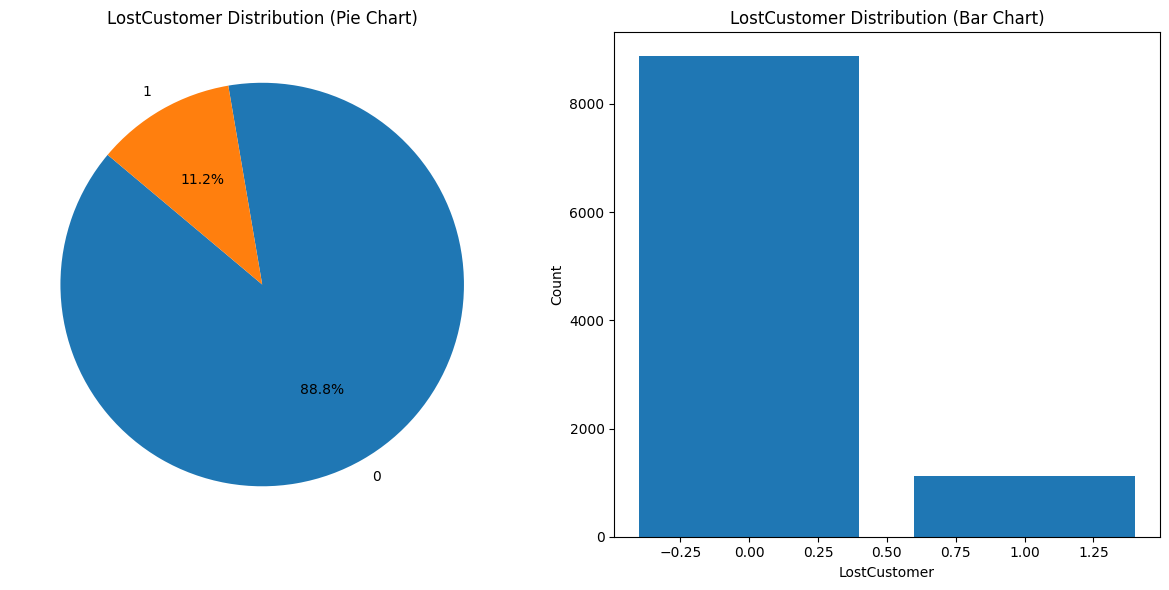

In [16]:
# looking at the target column
plot_distribution(df["LostCustomer"])

<div class="alert alert-info" role="alert">
Data is clearly very imbalanced which will lead to a biased prediction. There are many strategies we can use to counteract this such as oversampling where we increase the data contained in the smaller class or using class weights. 
</div>

<Axes: ylabel='regionPctCustomers'>

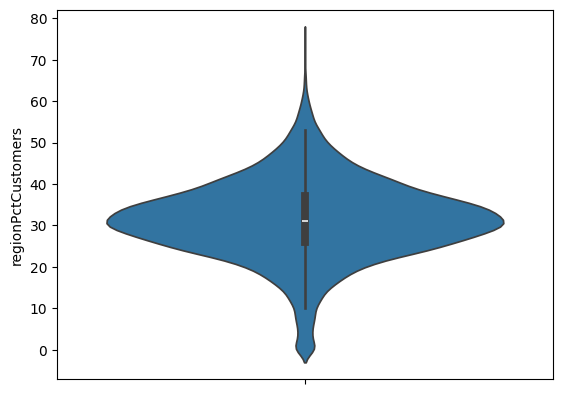

In [17]:
sns.violinplot(data=df, y="regionPctCustomers")

<Axes: xlabel='numOfTotalReturns', ylabel='count'>

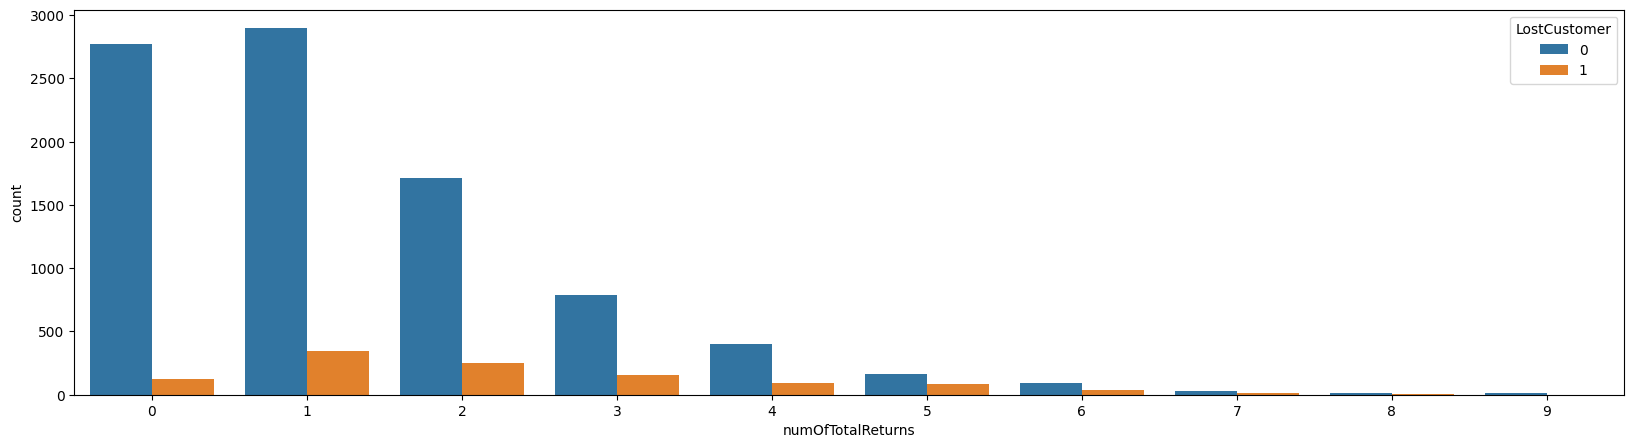

In [18]:
plt.figure(figsize=(20, 5))
sns.countplot(data=df, x="numOfTotalReturns", hue="LostCustomer")

<div class="alert alert-info" role="alert">
It can be seen that the number of returns is much higher for those retained customer as compared to those lost customers. 
</div>

<Axes: xlabel='wksSinceLastPurch', ylabel='Count'>

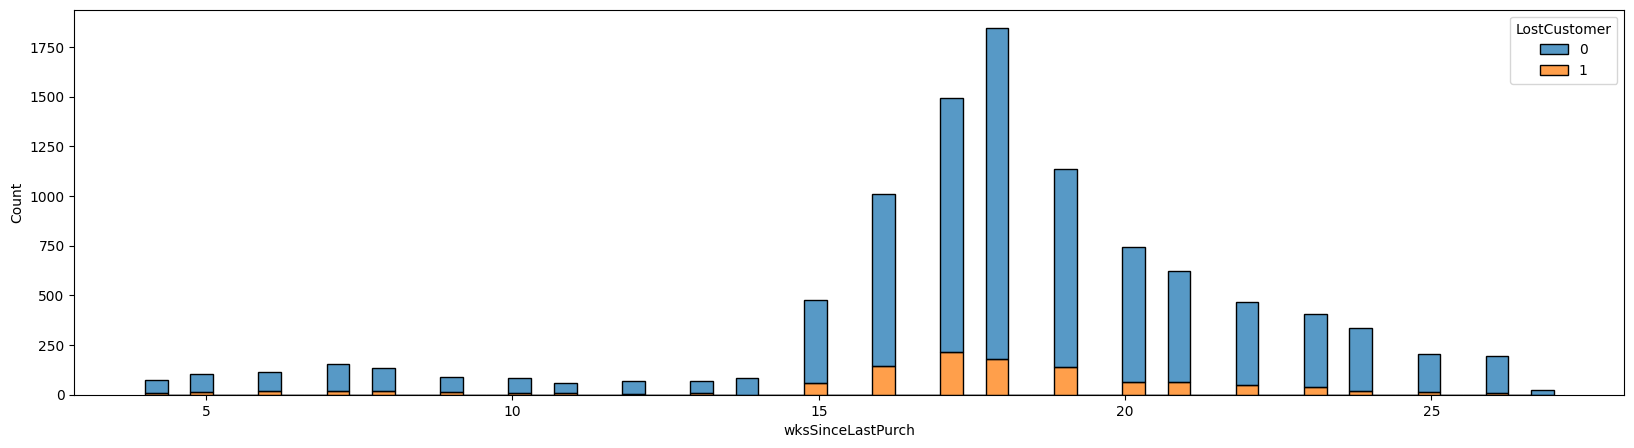

In [19]:
plt.figure(figsize=(20, 5))
sns.histplot(data=df, x="wksSinceLastPurch", hue="LostCustomer", multiple="stack")

<div class="alert alert-info" role="alert">
Based on the data, it appears that for the majority of customers, it has been approximately 15 to 20 weeks since their last purchase. The ecommerce store can address this by implementing targeted advertising strategies to encourage customers to return to their store.
</div>

<Axes: xlabel='basktPurchCount12Month', ylabel='count'>

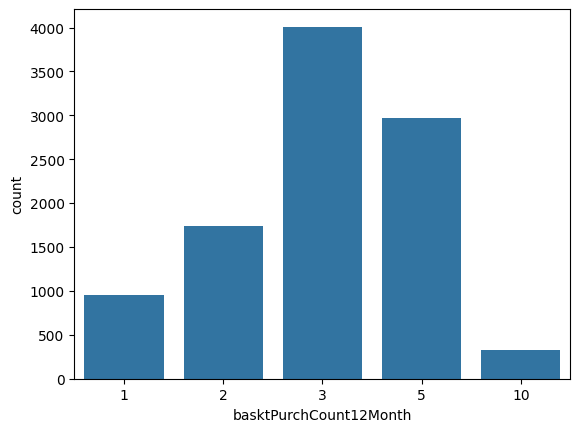

In [20]:
sns.countplot(data=df, x="basktPurchCount12Month")

<div class="alert alert-info" role="alert">
We can see that most of the items in the basket are 3 to 5 items. 
</div>

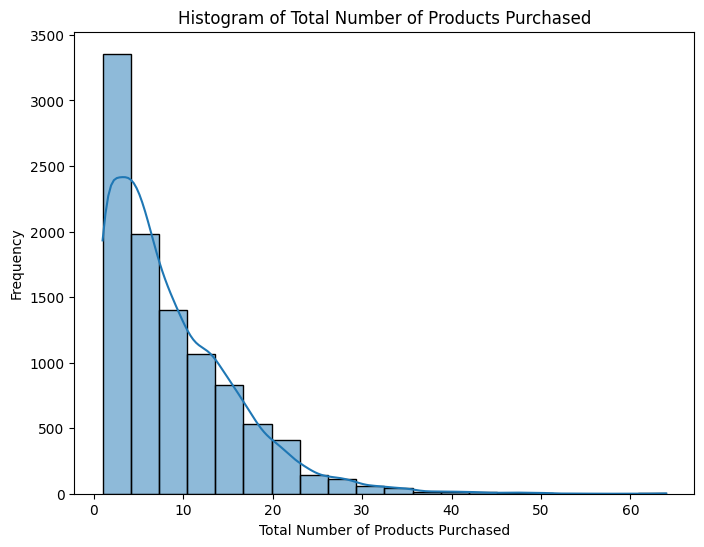

In [21]:
# Histogram of Total Number of Products Purchased
plt.figure(figsize=(8, 6))
sns.histplot(df['totalNumProdPurchased'], kde=True, bins=20)
plt.xlabel('Total Number of Products Purchased')
plt.ylabel('Frequency')
plt.title('Histogram of Total Number of Products Purchased')
plt.show()

<div class="alert alert-info" role="alert">
There is a right skew distribution for this, most of the customers are purchasing a small number of products. 
</div>

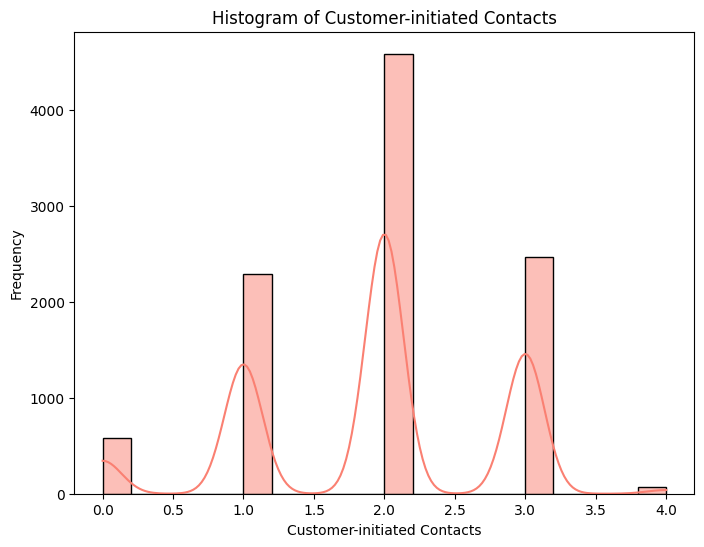

In [22]:
# Histogram of Customer-initiated Contacts
plt.figure(figsize=(8, 6))
sns.histplot(df['custInitiatedContacts'], kde=True, bins=20, color='salmon')
plt.xlabel('Customer-initiated Contacts')
plt.ylabel('Frequency')
plt.title('Histogram of Customer-initiated Contacts')
plt.show()

<div class="alert alert-info" role="alert">
2 is the highest number of customer initiated contacts. To increase the number of customer-initiated contacts, consider implementing strategies to encourage more engagement and interaction with the customer service channels.
</div>

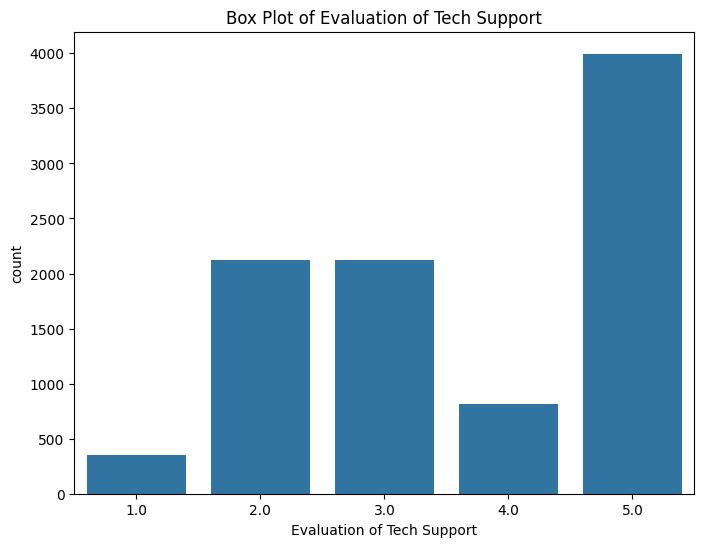

In [23]:
df['techSupportEval'] = df['techSupportEval'].replace('           .', np.nan)
df['techSupportEval'] = df['techSupportEval'].astype('float')
# Evaluation of Tech Support - Box Plot
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='techSupportEval')
plt.xlabel('Evaluation of Tech Support')
plt.title('Box Plot of Evaluation of Tech Support')
plt.show()

<div class="alert alert-info" role="alert">
We can see that the large majority of customers are happy with customer support which is a good sign and shows that this is not a very big issue to consider. 
</div>

In [24]:
df.columns

Index(['wksSinceFirstPurch', 'socialMediaAdCount36', 'wksSinceLastPurch',
       'intAdExposureCount12', 'totalNumProdPurchased', 'intAdExposureCount36',
       'socialMediaAdCountAll', 'regionPctCustomers', 'ID',
       'intAdExposureCountAll', 'DemHomeOwner', 'LostCustomer',
       'numOfTotalReturns', 'customerGender', 'basktPurchCount12Month',
       'customerSubscrStat', 'socialMediaAdCount12', 'custInitiatedContacts',
       'techSupportEval'],
      dtype='object')

<div class="alert alert-info" role="alert">
Overall, to improve the customer retention, the e-commerce company could offer larger discounts to customers who have churned, as purchasing power may be a contributing factor to their departure. This strategy aims to incentivize churned customers to continue purchasing items from the platform.
</div>

## EDA on Marketing and Advertising

- intAdExposureCount12: Internal ad exposure count in the last 12 months
- intAdExposureCount36: Internal ad exposure count in the last 36 months
- intAdExposureCountAll: Total internal ad exposure count
- socialMediaAdCount12: Social media ad exposure count in the last 12 months
- socialMediaAdCount36: Social media ad exposure count in the last 36 months
- socialMediaAdCountAll: Total social media ad exposure count

In [25]:
columns_to_keep = [
    "intAdExposureCount12",
    "intAdExposureCount36",
    "intAdExposureCountAll",
    "socialMediaAdCount12",
    "socialMediaAdCount36",
    "socialMediaAdCountAll"
]

df[columns_to_keep]

,intAdExposureCount12,intAdExposureCount36,intAdExposureCountAll,socialMediaAdCount12,socialMediaAdCount36,socialMediaAdCountAll
0,13.0,33.0,50.0,6,11.0,19.0
1,4.0,6.0,5.0,2,3.0,3.0
2,13.0,33.0,68.0,6,7.0,26.0
3,12.0,33.0,69.0,6,16.0,29.0
4,16.0,36.0,72.0,6,17.0,31.0
...,...,...,...,...,...,...
9995,10.0,24.0,56.0,5,5.0,22.0
9996,12.0,18.0,17.0,4,7.0,6.0
9997,13.0,34.0,57.0,6,6.0,23.0
9998,13.0,33.0,60.0,6,17.0,26.0


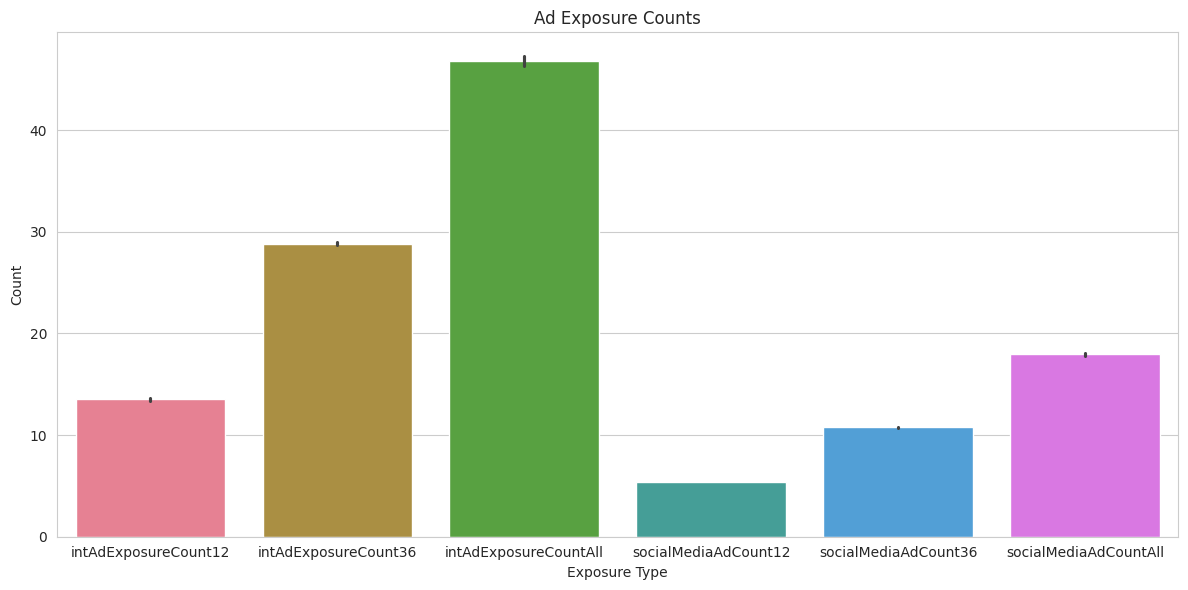

In [26]:
# Set the style
sns.set_style("whitegrid")

# Set the columns for each group
internal_ad_columns = ["intAdExposureCount12", "intAdExposureCount36", "intAdExposureCountAll"]
social_media_columns = ["socialMediaAdCount12", "socialMediaAdCount36", "socialMediaAdCountAll"]

# Melt the DataFrame for easier plotting
melted_df = df[columns_to_keep].melt(var_name="ExposureType", value_name="Count")

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x="ExposureType", y="Count", palette="husl")
plt.title("Ad Exposure Counts")
plt.xlabel("Exposure Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert">
Given that internal ad exposure is significantly higher than social media ad count, consider reallocating resources towards social media advertising to ensure a more balanced exposure across different platforms and potentially reach a wider audience.
</div>

## EDA on Customer Subscription Status:
- customerSubscrStat: Customer subscription status

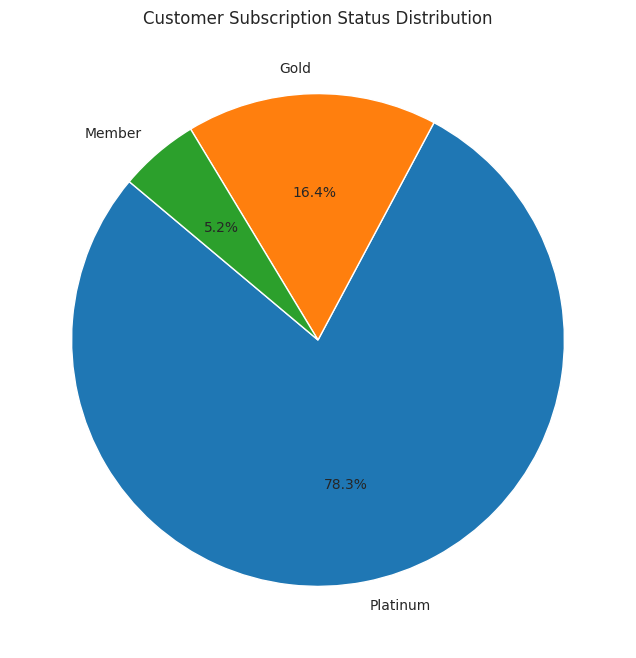

In [27]:
plt.figure(figsize=(8, 8))
df["customerSubscrStat"].value_counts().plot(kind="pie", autopct='%1.1f%%', startangle=140)
plt.title('Customer Subscription Status Distribution')
plt.ylabel('')  # Remove y-axis label
plt.show()

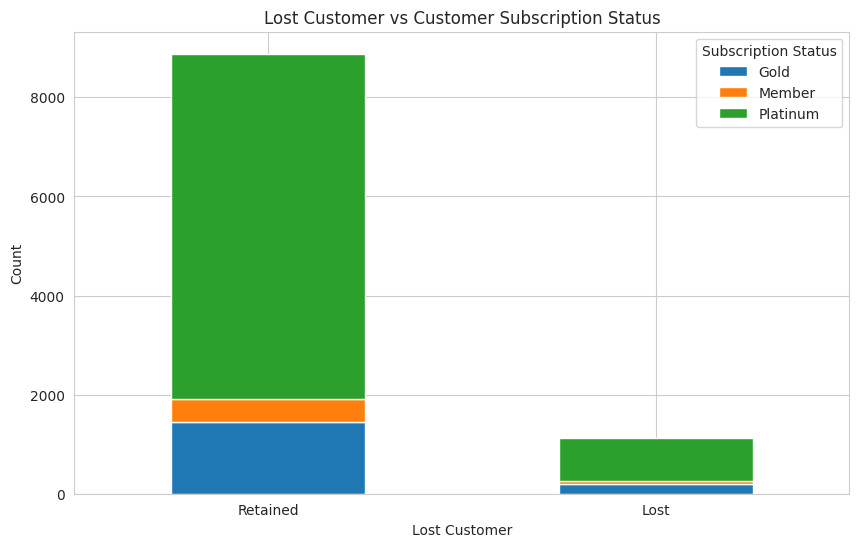

In [28]:
lost_customer_counts = df.groupby(["LostCustomer", "customerSubscrStat"]).size().unstack()

lost_customer_counts.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title('Lost Customer vs Customer Subscription Status')
plt.xlabel('Lost Customer')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Retained', 'Lost'], rotation=0)
plt.legend(title='Subscription Status')
plt.show()

<div class="alert alert-info" role="alert">
There is not much distinction between lost customers and retained customers in terms of their subscription status, indicating that subscription status may not be a significant factor influencing customer retention.
</div>

## EDA on collinearity

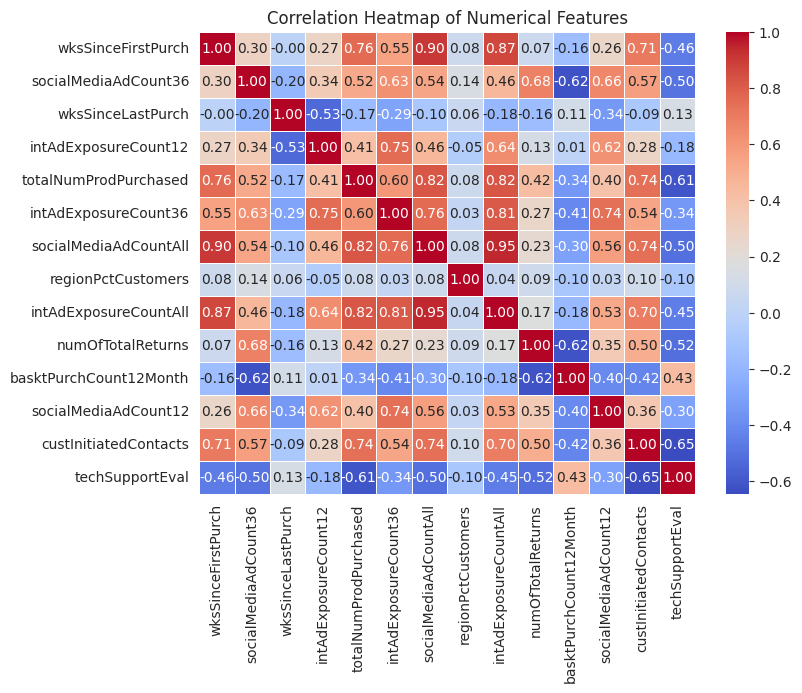

In [29]:
numerical_df = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numerical_df.drop(columns=["ID", "LostCustomer", "DemHomeOwner", "customerGender", "customerSubscrStat"], errors='ignore').corr()
plt.figure(figsize=(8,6))
sns.heatmap(data=corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

<div class="alert alert-info" role="alert">
We need to remove one of the columns that are highly correlated with each other due to multicollinearity. <br>
    - intAdExposureCountAll <br>
    - intAdExposureCount12 <br>
    - socialMediaAdCount12 <br>
</div>

# 4. Data Preparation and Modelling

In [30]:
df.drop(columns=["ID", "intAdExposureCountAll", "intAdExposureCount12", "socialMediaAdCount12"], inplace=True, errors='ignore')

df["techSupportEval"] =  df["techSupportEval"].replace('           .', np.nan)
df["techSupportEval"] = df["techSupportEval"].astype('float')

In [31]:
label_encoding = {
    'customerGender': {'F': 0, 'M': 1, 'U': 2},
    'DemHomeOwner': {'H': 0, 'U': 1},
    'customerSubscrStat': {'Platinum': 0, 'Gold': 1, 'Member': 2}
}

for col, mapping in label_encoding.items():
    df[col] = df[col].map(mapping)

In [32]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('SMOTEENN', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

X_train, X_valid, y_train, y_valid = train_test_split(df.drop(columns=["LostCustomer"]), df["LostCustomer"], test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

train_accuracy = accuracy_score(y_train, pipeline.predict(X_train))
test_accuracy = accuracy_score(y_valid, pipeline.predict(X_valid))

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.999375
Test Accuracy: 0.927


<div class="alert alert-info" role="alert">
Looking at the accuracy itself is not a good idea since the dataset is imbalanced. We must look at the overall results which can be achieved through using the classification report. 
</div>

In [33]:
test_report = classification_report(y_valid, pipeline.predict(X_valid), output_dict=True)
pd.DataFrame(test_report).T["recall"]

0               0.979213
1               0.504545
accuracy        0.927000
macro avg       0.741879
weighted avg    0.927000
Name: recall, dtype: float64

<div class="alert alert-info" role="alert">
The data that the model is receiving is heavily imbalanced so there is a ceiling in terms of model performance no matter the optimizations that we apply on it. However, there is one metric which is of importance to us which is recall. A high recall score tells us that the model is good at identifying the churned customers and is unlikely to miss identifying these customers.  
</div>

# 5. Tuning Pipeline and Models

In [34]:
rf_classifier = pipeline.named_steps['classifier']

# getting the feature importance of the model
feature_importances = rf_classifier.feature_importances_
feature_importances.__len__(), X_train.columns.__len__()

(14, 14)

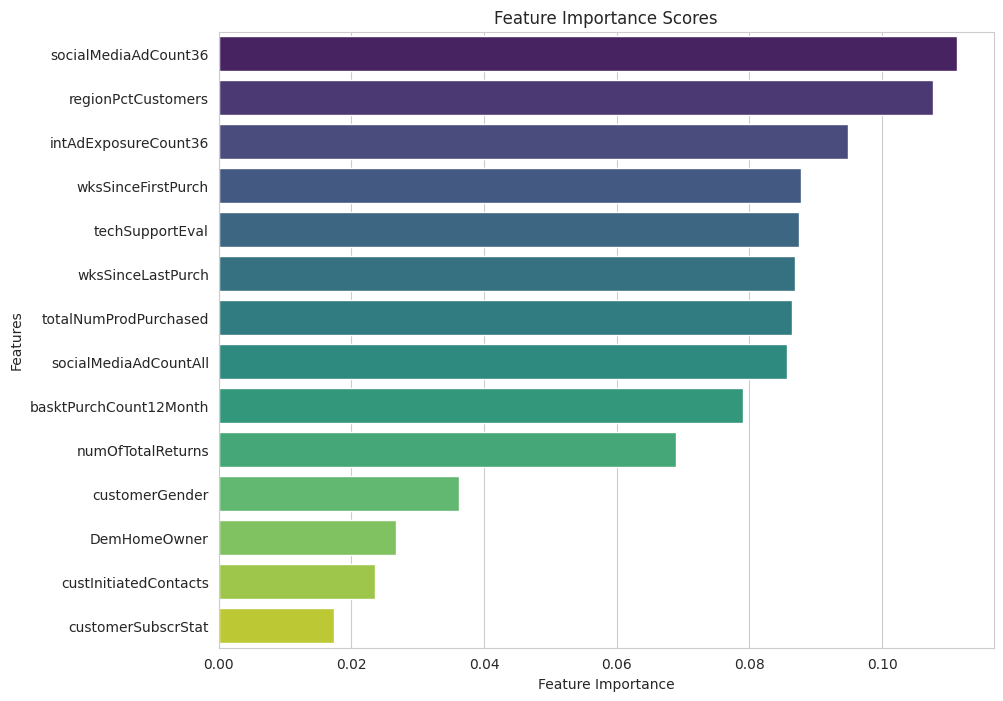

In [35]:
rf_classifier = pipeline.named_steps['classifier']

# getting the feature importance of the model
feature_scores = pd.Series(rf_classifier.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_scores, y=feature_scores.index, orient='h', palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Scores')
plt.show()

<div class="alert alert-info" role="alert">
Looking at the feature importance we did try to eliminate those features with low importance but it did not lead to any performance improvement for the model. For this reason we will now have to tune the model hyperparameters. Before that let's try ensemble techniques like bagging on the decision tree and see if that improves the performance. 
</div>

In [36]:
# lets add a balanced bagging classifier

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('SMOTE', SMOTE(random_state=42)),
    ('classifier', BalancedBaggingClassifier(
        estimator=DecisionTreeClassifier(),
        sampling_strategy='not majority',
        replacement=False,
        n_jobs=-1,
        random_state=42)
    )
])

pipeline.fit(X_train, y_train)

train_accuracy = accuracy_score(y_train, pipeline.predict(X_train))
test_accuracy = accuracy_score(y_valid, pipeline.predict(X_valid))

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.9955
Test Accuracy: 0.91


In [37]:
test_report = classification_report(y_valid, pipeline.predict(X_valid), output_dict=True)
pd.DataFrame(test_report).T["recall"]

0               0.968539
1               0.436364
accuracy        0.910000
macro avg       0.702451
weighted avg    0.910000
Name: recall, dtype: float64

<div class="alert alert-info" role="alert">
The scores have improved in terms of accuracy and precision but the recall for the minority class has reduced significantly. This shows that bagging may not be a suitable technique to make use of. 
</div>

In [38]:
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=True)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('SMOTE', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

In [39]:
# Define hyperparameter space
space = {
    'classifier__max_depth': hp.quniform('max_depth', 1, 15, 1),
    'classifier__min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'classifier__n_estimators': hp.quniform('n_estimators', 50, 200, 1)
}

# Objective function
def objective(params):
    pipeline.set_params(classifier__max_depth=int(params['classifier__max_depth']),
                        classifier__min_samples_split=int(params['classifier__min_samples_split']),
                        classifier__n_estimators=int(params['classifier__n_estimators']))
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_valid)
    recall = recall_score(y_valid, y_pred)
    
    return {'loss': -recall, 'status': STATUS_OK}

# Hyperparameter tuning
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

best_params = space_eval(space, best)
best_recall = -trials.best_trial['result']['loss']

print("Best Parameters:", best_params)
print("Best Recall:", best_recall)

100%|██████████| 50/50 [00:54<00:00,  1.08s/trial, best loss: -0.6409090909090909]
Best Parameters: {'classifier__max_depth': 6.0, 'classifier__min_samples_split': 7.0, 'classifier__n_estimators': 170.0}
Best Recall: 0.6409090909090909


In [40]:
# updating the model with new hyperparameters obtained from the bayesian optimization
# columns to drop ["ID", "intAdExposureCountAll", "intAdExposureCount12", "socialMediaAdCount12"]

pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=True)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('SMOTE', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(max_depth=9, min_samples_split=3, n_estimators=131, class_weight='balanced', random_state=42))
])

In [41]:
pipeline.fit(X_train, y_train)

train_accuracy = accuracy_score(y_train, pipeline.predict(X_train))
test_accuracy = accuracy_score(y_valid, pipeline.predict(X_valid))

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.868875
Test Accuracy: 0.832


In [42]:
test_report = classification_report(y_valid, pipeline.predict(X_valid), output_dict=True)
pd.DataFrame(test_report).T["recall"]

0               0.857865
1               0.622727
accuracy        0.832000
macro avg       0.740296
weighted avg    0.832000
Name: recall, dtype: float64

<div class="alert alert-info" role="alert">
This is the model's best performance for recall after hyperparameter tuning. We can see that it took a lot of effort to get to this stage. Now let us attempt to do the same thing using SAS viya model libraries.
</div>

In [43]:
from sasviya.ml.tree import ForestClassifier

pipeline2 = Pipeline([
    ('scaler', StandardScaler(with_mean=True)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('SMOTEENN', SMOTE(random_state=42)),
    ('classifier', ForestClassifier(random_state=70))
])

pipeline2.fit(X_train, y_train)
test_report = classification_report(y_valid, pipeline2.predict(X_valid), output_dict=True)
pd.DataFrame(test_report).T["recall"]

0               0.752247
1               0.713636
accuracy        0.748000
macro avg       0.732942
weighted avg    0.748000
Name: recall, dtype: float64

<div class="alert alert-info" role="alert">
As seen from the result the SAS viya models significantly outperform the sklearn models by 20% on recall which is a very good sign. This is the raw, untuned model. Further tuning this model will yield much better results.
</div>

In [44]:
data = {
    'Model': ['Base RF Classifier', 'RF Classifier with Ensemble Techniques', 
              'RF Classifier after Hyperparameter Tuning', 'SAS Viya Forest Model'],
    'Recall on Churned Customers': [0.50, 0.43, 0.62, 0.70]
}

score_comparison = pd.DataFrame(data).set_index("Model").T


styled_table = score_comparison.style.background_gradient(cmap='YlGnBu', axis=1)
styled_table

Model,Base RF Classifier,RF Classifier with Ensemble Techniques,RF Classifier after Hyperparameter Tuning,SAS Viya Forest Model
Recall on Churned Customers,0.500000,0.430000,0.620000,0.700000


# 6. Deployment

## a. Exporting Pipeline Objects to .pkl files

### i. sci-kit learn pipeline

In [45]:
# dump the pipeline object
with open('sklearn_pipeline_v2.pkl', 'wb') as file:
    pickle.dump(pipeline, file)


del pipeline

# load the pipeline object
with open('./sklearn_pipeline_v2.pkl', mode='rb') as file:
    pipeline = pickle.load(file)
pipeline

Pipeline(steps=[('scaler', StandardScaler()), ('imputer', SimpleImputer()),
                ('SMOTE', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=9,
                                        min_samples_split=3, n_estimators=131,
                                        random_state=42))])

### ii. SAS pipeline

In [46]:
with open('sas_pipeline_v2.pkl', 'wb') as file:
    pickle.dump(pipeline2, file)

del pipeline

# load the pipeline object
with open('./sas_pipeline_v2.pkl', mode='rb') as file:
    pipeline2 = pickle.load(file)
pipeline2

Pipeline(steps=[('scaler', StandardScaler()), ('imputer', SimpleImputer()),
                ('SMOTEENN', SMOTE(random_state=42)),
                ('classifier', ForestClassifier(random_state=70))])

In [47]:
test_accuracy = classification_report(y_valid, pipeline2.predict(X_valid))
pprint(test_accuracy)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.96      0.75      0.84      1780\n'
 '           1       0.26      0.71      0.38       220\n'
 '\n'
 '    accuracy                           0.75      2000\n'
 '   macro avg       0.61      0.73      0.61      2000\n'
 'weighted avg       0.88      0.75      0.79      2000\n')


## b. Deploying to SAS Model Manager

In [50]:
load_dotenv(find_dotenv())
refresh_token = os.environ.get("ACCESS_TOKEN")

In [51]:
# get access token for viya env using refresh token. change to your own viya server and preferred authentication method.
url = "https://apgtps2demo.gtp.unx.sas.com"
auth_url = f"{url}/SASLogon/oauth/token"

# reading long-lived refresh token from txt file

payload=f'grant_type=refresh_token&refresh_token={refresh_token}'
headers = {
  'Accept': 'application/json',
  'Content-Type': 'application/x-www-form-urlencoded',
  'Authorization': 'Basic c2FzLmNsaTo=',
}

response = requests.request("POST", auth_url, headers=headers, data=payload, verify=False)
access_token = response.json()['access_token']

st = Session("https://apgtps2demo.gtp.unx.sas.com", token=access_token, verify_ssl=False)
st

### a. Publishing sklearn model to SAS model manager

In [52]:
%%writefile ./sklearn_mm_assets/sklearn_model_score.py
import settings
from imblearn.pipeline import Pipeline
import pickle
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier

def computeScore(intAdExposureCount36,wksSinceLastPurch,wksSinceFirstPurch,totalNumProdPurchased,socialMediaAdCountAll,socialMediaAdCount36,regionPctCustomers,DemHomeOwner,numOfTotalReturns,customerGender,basktPurchCount12Month,customerSubscrStat,custInitiatedContacts,techSupportEval):
    "Output: P_LostCustomer0, P_LostCustomer1, I_LostCustomer"
    try:
        dm_model
    except NameError:
        with open(settings.pickle_path+'/sklearn_pipeline_v2.pkl', "rb") as f:
        	dm_model = pickle.load(f)

    ## Define input dataframe to score
    input_list=[intAdExposureCount36,wksSinceLastPurch,wksSinceFirstPurch,totalNumProdPurchased,socialMediaAdCountAll,socialMediaAdCount36,regionPctCustomers,DemHomeOwner,numOfTotalReturns,customerGender,basktPurchCount12Month,customerSubscrStat,custInitiatedContacts,techSupportEval]
    X = pd.DataFrame(input_list).T
    X.columns=(['intAdExposureCount36', 'wksSinceLastPurch',
       'wksSinceFirstPurch', 'totalNumProdPurchased',
       'socialMediaAdCountAll', 'socialMediaAdCount36', 'regionPctCustomers',
        'DemHomeOwner', 'numOfTotalReturns',
       'customerGender', 'basktPurchCount12Month', 'customerSubscrStat',
       'custInitiatedContacts', 'techSupportEval'])

    X["techSupportEval"] =  X["techSupportEval"].replace('           .', np.nan)
    X["techSupportEval"] = X["techSupportEval"].astype('float')

    label_encoding = {
        'customerGender': {'F': 0, 'M': 1, 'U': 2},
        'DemHomeOwner': {'H': 0, 'U': 1},
        'customerSubscrStat': {'Platinum': 0, 'Gold': 1, 'Member': 2}
    }

    for col, mapping in label_encoding.items():
        X[col] = X[col].map(mapping)
    
    ## predict
    P_LostCustomer0 = dm_model.predict_proba(X)[0,0]
    P_LostCustomer1 = dm_model.predict_proba(X)[0,1]
    I_LostCustomer = dm_model.predict(X)

    return float(P_LostCustomer0), float(P_LostCustomer1), str(int(I_LostCustomer))

Overwriting ./sklearn_mm_assets/sklearn_model_score.py


In [53]:
pzmm.JSONFiles.write_var_json(df[
        ['intAdExposureCount36', 'wksSinceLastPurch',
       'wksSinceFirstPurch', 'totalNumProdPurchased',
       'socialMediaAdCountAll', 'socialMediaAdCount36', 'regionPctCustomers',
        'DemHomeOwner', 'numOfTotalReturns',
       'customerGender', 'basktPurchCount12Month', 'customerSubscrStat',
       'custInitiatedContacts', 'techSupportEval']], is_input=True, json_path="/workspaces/myfolder/sklearn_mm_assets/")

inputVar.json was successfully written and saved to /workspaces/myfolder/sklearn_mm_assets/inputVar.json


In [54]:
target_df =pd.DataFrame(data=[[0.5,0.5,"1"]],columns=['P_LostCustomer0','P_LostCustomer1','I_LostCustomer'])
pzmm.JSONFiles.write_var_json(target_df, is_input=False, json_path="/workspaces/myfolder/sklearn_mm_assets/")

outputVar.json was successfully written and saved to /workspaces/myfolder/sklearn_mm_assets/outputVar.json


In [55]:
model_name = "sklearn_pipeline_model"

pzmm.JSONFiles.write_model_properties_json(model_name=model_name,
                            model_desc='scikit learn random forest model pipeline',
                            target_variable='LostCustomer',
                            model_algorithm='scikit-learn.RandomForestClassifier',
                            target_values=["1","0"],
                            json_path="/workspaces/myfolder/sklearn_mm_assets/",
                            modeler='Karthik')

ModelProperties.json was successfully written and saved to /workspaces/myfolder/sklearn_mm_assets/ModelProperties.json


In [56]:
repository = mr.get_repository('DMRepository')
repository.name

/usr/local/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'apgtps2demo.gtp.unx.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


'DMRepository'

In [57]:
project_name = "CDA DEMO (EBS) Churn Prediction"

try:
    project = mr.create_project(project_name, repository)
except:
    project = mr.get_project(project_name)

In [58]:
import_model = pzmm.ImportModel.import_model(
    overwrite_model=True,
    model_files="/workspaces/myfolder/sklearn_mm_assets/",
    model_prefix=model_name,
    project=project_name, 
    input_data=X_train,
    predict_method='{}.predict_proba({})',
    target_values=["1","0"]
)

All model files were zipped to /workspaces/myfolder/sklearn_mm_assets.


In [59]:
## On-demand Score code

model = mr.get_model(model_name)

scorefile = mr.add_model_content(
    model,
    open('/workspaces/myfolder/sklearn_mm_assets/sklearn_model_score.py', 'rb'),
    name='sklearn_model_score.py',
    role='score'
)

In [60]:
pklFileName = f'/workspaces/myfolder/sklearn_pipeline_v2.pkl'

python_pickle = mr.add_model_content(
    model,
    open(pklFileName, 'rb'),
    name=pklFileName,
    role='python pickle'
)

### b. Deploying SAS model to SAS model manager

It's a very simple 3 step process for deploying the models into model manager. 
1. export the model as an astore object
2. specify model parameters
3. push the model into model manager

In [67]:
# to just deploy a SAS viya model without pipeline, it is much easier

# export the model as an astore object
sasrf = ForestClassifier(max_features=None, random_state=42)
sasrf.fit(X_train, y_train)
sasrf.export(
    file = "model_export.astore", replace=True
)

In [68]:
# specify the model parameters
model_params = {
    "name": "ViyaWorkbench_SASRF_pipeline",
    "projectId": project.id,
    "type": "ASTORE",
}

# push the model the model manager
astore = mr.post(
    "/models",
    files={"files": (f"model_export.astore",sasrf.export())},
    data=model_params,
)

/usr/local/lib/python3.11/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'apgtps2demo.gtp.unx.sas.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


### c. Exporting validation data as csv for testing

In [ ]:
X_valid.to_csv("churn_prediction_validation.csv")